In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('..')
from notebook_utils import Data, train, run_study, test_vanilla, test_uncertain

sys.path.append('../../..')
from uncertain.pairwise_ranking.MF import bprMF, UncertainMF, PretrainedUncertainMF
from uncertain.extras import Resample


if os.path.isfile('data.pkl'):
    with open('data_used.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data loaded: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data.drop(columns='timestamps'))
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
base_conf = {'embedding_dim':10, 'lr':0, 'weight_decay':0}
trials = 0 ## 0 for eval only mode

MovieLens data loaded: 6040 users, 3416 items.
602195 train, 197526 validation and 199890 test interactions.


In [2]:
f'batch size: ({2**8}, {2**10}) - learning rate: ({1e-5}, {1e-3} - weight_decay: {1e-5, 1e-3})'

'batch size: (256, 1024) - learning rate: (1e-05, 0.001 - weight_decay: (1e-05, 0.001))'

# Popularity

In [3]:
name = 'Popularity'
pop_rec = data.item_support.argsort()[::-1]
max_k = 10

precision_denom = np.arange(1, max_k+1)
MAP = np.zeros((data.n_user, max_k))
Recall = np.zeros((data.n_user, max_k))

for user in range(data.n_user):
    targets = data.test[data.test[:, 0] == user, 1]
    rated_train = data.train[:, 1][data.train[:, 0] == user]
    rated_val = data.val[:, 1][data.val[:, 0] == user]
    rated = np.concatenate([rated_train, rated_val])
    
    rec = pop_rec[~np.isin(pop_rec, rated)][:max_k]
    hits = np.isin(rec, targets)
    n_hits = hits.cumsum(0)
    
    if n_hits[-1] > 0:
        precision = n_hits / precision_denom
        MAP[user] = np.cumsum(precision * hits, 0) / np.maximum(n_hits, 1)
        Recall[user] = n_hits / len(targets)
    
metrics = {'MAP': MAP, 'Recall': Recall}
with open('results/' + name + '.pkl', 'wb') as f:
    pickle.dump(metrics, file=f)
    
metrics['MAP'].mean(0), metrics['Recall'].mean(0)

(array([0.25678808, 0.325     , 0.34522627, 0.35372517, 0.35614261,
        0.35529346, 0.35261509, 0.35080664, 0.34747324, 0.34352728]),
 array([0.01108605, 0.02033238, 0.02818101, 0.03535304, 0.04199172,
        0.04793785, 0.05297879, 0.05820358, 0.06354911, 0.06850716]))

# MF-BPR

In [ ]:
name = 'MF-BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3)}
    '''
    'weight_decay': (trial.suggest_float('wd_user', 1e-4, 1e-2), 
                     trial.suggest_float('wd_item', 1e-4, 1e-2), 
                     trial.suggest_float('wd_neg_item', 1e-4, 1e-2))
    '''
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
baseline = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(baseline, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 1.2 M 
1 | item_embeddings | Embedding | 683 K 
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.565     Total estimated model params size (MB)
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/vcoscrato/Documents/RecSys/MF/tests/Pairwise/ML1M/checkpoints/MF-BPR exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Resample

[0.41986755 0.50703645 0.5333747  0.5371229  0.53555    0.5297015
 0.5238432  0.5168543  0.5104244  0.50286376] 0.823269344607913 -0.23151879321709984


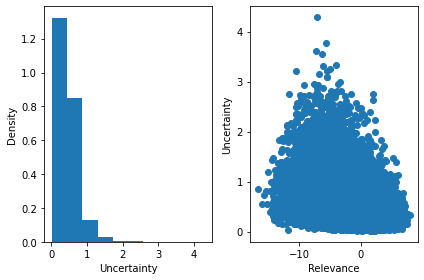

In [3]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}

# Train
if trials > 0:
    og = deepcopy(data.train)
    for i in range(5):
        data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
        model = init_model(**best_params)
        train(model, data, path='checkpoints/resample', name=f'{i}')
    data.train = og
    
# Load resample models
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0]), models)
results = test_uncertain(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
print(results['MAP'], results['PUR'], results['UAC'])

In [4]:
results['unc_MAP']

array([0.44315687, 0.4502776 , 0.46000862, 0.4709814 , 0.48464826,
       0.50286376, 0.48372722, 0.47072172, 0.4590656 , 0.45135236,
       0.44412637], dtype=float32)

# UMF-GPR-notailchasing

[0.46771523 0.54014903 0.5588852  0.5611295  0.5591708  0.55351853
 0.5470642  0.53940964 0.5313     0.52523196] 0.9940985 -0.19524916681365043


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
0,0,0.865577,2022-06-28 10:09:10.240195,2022-06-28 10:29:11.512061,0 days 00:20:01.271866,462,200,6,0.000475,0.000043,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


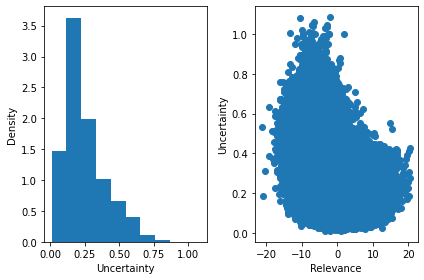

In [2]:
name = 'UMF-GPR-notailchasing'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 5, 50),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    
    # Freeze uncertainty
    for param in model.user_var.parameters():
        param.requires_grad = False
    for param in model.item_var.parameters():
        param.requires_grad = False
     
    _, path = train(model, data, path='checkpoints/' + name, name=params_str)
    model.load_from_checkpoint(path)
    
    # Unfreeze uncertainty
    for param in model.user_var.parameters():
        param.requires_grad = True
    for param in model.item_var.parameters():
        param.requires_grad = True
        
    # Freeze mean
    for param in model.user_mean.parameters():
        param.requires_grad = False
    for param in model.item_mean.parameters():
        param.requires_grad = False
    
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'], results['PUR'], results['UAC'])
best_runs

In [6]:
np.mean(results['norm_unc'][0]), np.mean(results['norm_unc'][1])

(0.06122086304018613, -0.030182920331183916)

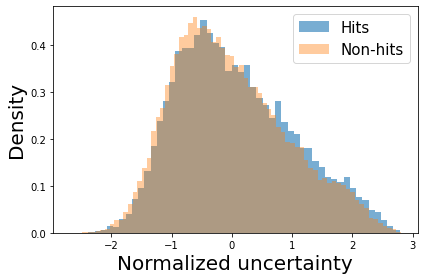

In [29]:
f, ax = plt.subplots()
plt.hist(results['norm_unc'][0], bins='auto', alpha=0.6, density=True, label='Hits')
plt.hist(results['norm_unc'][1], bins='auto', alpha=0.4, density=True, label='Non-hits')
plt.legend(fontsize=15)
plt.xlabel('Normalized uncertainty', fontsize=20)
plt.ylabel('Density', fontsize=20)
f.tight_layout()
f.savefig('plots/normalized_uncertainty.pdf')

In [5]:
import torch

Text(0, 0.5, 'Density')

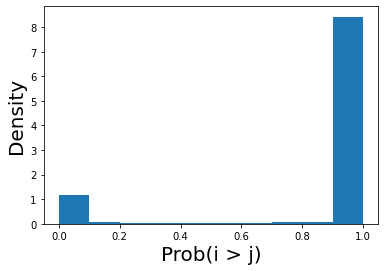

In [14]:
preds = model.predict(data.test[:, 0], data.test[:, 1])

rng = np.random.default_rng(0)
rand_items = rng.integers(data.n_item, size=len(data.test) * 5)
rand_users = np.concatenate([data.test[:, 1] for _ in range(5)])
rand_preds = model.predict(rand_users, rand_items)

with torch.no_grad():
    probs = model.train_val_step(torch.tensor(data.test[:, 0]), torch.tensor(data.test[:, 1]), penalize=False)
    
f, ax = plt.subplots()
ax.hist(probs.numpy(), density=True)
ax.set_xlabel('Prob(i > j)', fontsize=20)
ax.set_ylabel('Density', fontsize=20)

Text(0, 0.5, 'Density')

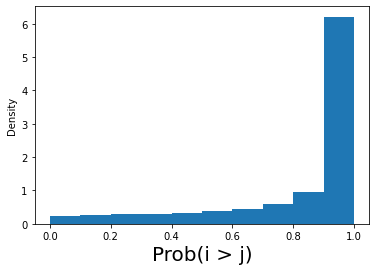

In [13]:
preds = baseline.predict(data.test[:, 0], data.test[:, 1])

rng = np.random.default_rng(0)
rand_items = rng.integers(data.n_item, size=len(data.test) * 5)
rand_users = np.concatenate([data.test[:, 1] for _ in range(5)])
rand_preds = baseline.predict(rand_users, rand_items)

with torch.no_grad():
    probs = baseline.train_val_step(torch.tensor(data.test[:, 0]), torch.tensor(data.test[:, 1]), penalize=False)

f, ax = plt.subplots()
ax.hist(probs.numpy(), density=True)
ax.set_xlabel('Prob(i > j)', fontsize=20)
ax.set_ylabel('Density', fontsize=20)

# Results

In [8]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '')] = pickle.load(open(os.path.join('results', key), 'rb'))
results['BPR'] = results.pop('MF-BPR')
results['GPR'] = results.pop('UMF-GPR-notailchasing')
order = ['BPR', 'GPR']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Results
results[['FCP', 'CP unc', 'DP unc', 'PUR', 'URI', 'UAC']]

,FCP,CP unc,DP unc,PUR,URI,UAC
BPR,0.859323,NaN,NaN,NaN,NaN,NaN
GPR,0.865236,0.151413,0.152312,0.994098,-0.058745,-0.195249


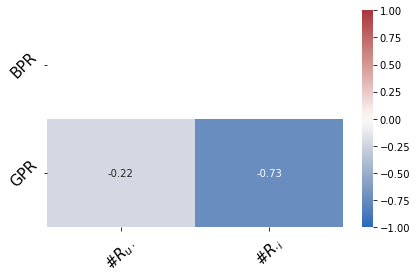

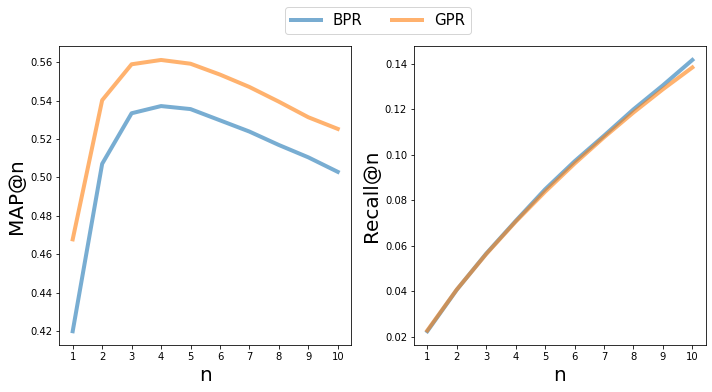

In [16]:
## Correlation plot
corr = results.filter(like='corr', axis=1)
corr.columns = [r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=2, bbox_to_anchor=(0.67, 1.1))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches="tight")

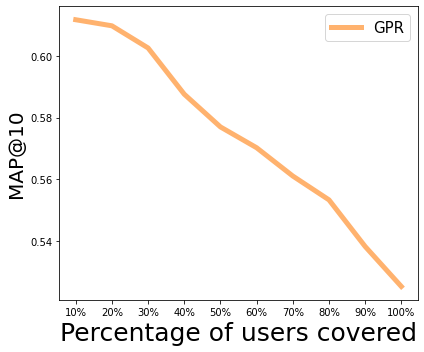

In [20]:
## MAP vs Coverage
f, ax = plt.subplots(figsize=(6, 5))
x = np.linspace(100, 10, 10)
for index, row in results.drop(['BPR']).iterrows():
    ax.plot(x, row['MAP-covered'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax.set(xticks = x, xticklabels = [str(int(x)) + '%' for x in x])
ax.set_xlabel('Percentage of users covered', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

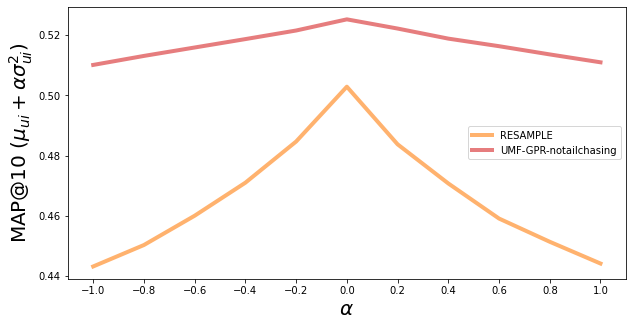

In [24]:
f, ax = plt.subplots(figsize=(10, 5))
for index, row in results.drop(['MF-BPR', 'UMF-GPR', 'UMF-GPR-notailchasing-log'], axis=0).iterrows():
    ax.plot(np.linspace(-1, 1, 11), row['unc_MAP'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
ax.set_xticks(np.linspace(-1, 1, 11))
ax.set_xlabel(r'$\alpha$', fontsize=20)
ax.set_ylabel(r'MAP@10 ($\mu_{ui} + \alpha \sigma^2_{ui}$)', fontsize=20)
ax.legend()

In [11]:
results['unc_MAP']

MF-BPR                                                                     NaN
RESAMPLE                     [0.44315687, 0.4502776, 0.46000862, 0.4709814,...
UMF-GPR                                                                    NaN
UMF-GPR-notailchasing        [0.510093, 0.51308584, 0.5158824, 0.5186756, 0...
UMF-GPR-notailchasing-log                                                  NaN
Name: unc_MAP, dtype: object